In [2]:
import os
import re
from pathlib import Path
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb

In [3]:
mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
def display_all(df):
    plot_cols = df.columns
    plot_features = df[plot_cols]
    plot_features.index = df.index
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:960]
    plot_features.index = df.index[:960]
    _ = plot_features.plot(subplots=True)

def analyze_fill_results(original_df, filled_df):
    """
    วิเคราะห์ผลลัพธ์การ fill ข้อมูล
    """
    print("\n" + "="*50)
    print("การวิเคราะห์ผลลัพธ์การ Fill ข้อมูล")
    print("="*50)
    
    # เปรียบเทียบ missing values ก่อนและหลัง
    numeric_cols = original_df.select_dtypes(include=[np.number]).columns
    
    print("\nการเปรียบเทียบ Missing Values:")
    print("คอลัมน์".ljust(25) + "ก่อน fill".ljust(12) + "หลัง fill".ljust(12) + "ลดลง")
    print("-" * 60)
    
    total_reduction = 0
    for col in numeric_cols:
        if col in original_df.columns and col in filled_df.columns:
            before = original_df[col].isnull().sum()
            after = filled_df[col].isnull().sum()
            reduction = before - after
            total_reduction += reduction
            
            print(f"{col.ljust(25)}{str(before).ljust(12)}{str(after).ljust(12)}{reduction}")
    
    print("-" * 60)
    print(f"รวมลดลง: {total_reduction} missing values")
    
    # แสดงสถิติพื้นฐาน
    print("\nสถิติพื้นฐานหลัง fill:")
    important_cols = ['Current Power', 'Grid Feed In', 'Internal Power Supply', 
                     'Ambient Temperature', 'Module Temperature', 'Total Irradiation']
    
    for col in important_cols:
        if col in filled_df.columns:
            print(f"\n{col}:")
            print(f"  ค่าเฉลี่ย: {filled_df[col].mean():.2f}")
            print(f"  สูงสุด: {filled_df[col].max():.2f}")
            print(f"  ต่ำสุด: {filled_df[col].min():.2f}")
            print(f"  Missing: {filled_df[col].isnull().sum()}")

In [5]:
csv_file = tf.keras.utils.get_file(
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/merge_15min_filled.csv.tar.gz')
csv_file

'C:\\Users\\ASUS\\.keras\\datasets\\merge_15min_filled.csv.tar.gz'

In [6]:
df = pd.read_csv(csv_file)
row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 138238


,datetime,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
0,2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,0.0,9238.933333,37280.422222,37280.422222,58.022222,798.444444,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
1,2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,0.0,9397.756098,39132.406593,39132.406593,58.263736,812.571429,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2,2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,0.0,14387.595506,32669.393258,32669.393258,57.235955,807.224719,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
3,2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,0.0,12289.318681,36126.516484,36126.516484,56.846154,817.527473,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936
4,2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,0.0,12465.438202,36879.966292,36879.966292,55.842697,816.651685,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936


In [7]:
# Check what years exist in your dataset
date_col = 'datetime'  # Replace with your actual column name

df = df.sort_values(date_col).reset_index(drop=True)

# Ensure timestamp column is datetime type
if df[date_col].dtype != 'datetime64[ns]':
    df[date_col] = pd.to_datetime(df[date_col])

# Sort by time if it exists
df.index = df[date_col]
df.pop(date_col)
df = df.sort_index()
print(df.shape)
df.head(5)

(138238, 28)


,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation,utci_mean,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,0.0,9238.933333,37280.422222,37280.422222,58.022222,798.444444,302.213731,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,0.0,9397.756098,39132.406593,39132.406593,58.263736,812.571429,302.213731,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,0.0,14387.595506,32669.393258,32669.393258,57.235955,807.224719,302.213731,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,0.0,12289.318681,36126.516484,36126.516484,56.846154,817.527473,299.223424,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936
2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,0.0,12465.438202,36879.966292,36879.966292,55.842697,816.651685,299.223424,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936


In [8]:
print(df.index.year.unique())
print(df.index.year.value_counts())

Index([2021, 2022, 2023, 2024, 2025], dtype='int32', name='datetime')
datetime
2024    35136
2023    35040
2022    35040
2025    27691
2021     5331
Name: count, dtype: int64


In [12]:
#display_all(df)

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ambient_temperature,138238.0,2.583504e+01,5.150631e+00,0.000000e+00,2.310989e+01,2.600000e+01,2.913483e+01,4.001099e+01
current_power,138238.0,1.305281e+04,1.815287e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.526932e+04,7.825989e+04
current_value_of_consumption,138238.0,1.175896e+04,1.289041e+04,0.000000e+00,6.292220e+03,7.790966e+03,1.153213e+04,1.452448e+05
external_energy_supply,138238.0,6.303765e+03,7.008863e+03,0.000000e+00,0.000000e+00,6.743865e+03,8.341677e+03,1.452448e+05
grid_feed_in,138238.0,8.960647e+03,1.839218e+04,0.000000e+00,0.000000e+00,0.000000e+00,7.828382e+03,1.511431e+05
internal_power_supply,138238.0,5.468012e+03,1.032596e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.489396e+03,7.489512e+04
self_consumption,138238.0,5.468012e+03,1.032596e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.489396e+03,7.489512e+04
temperature_measurement,138238.0,2.972648e+01,1.188849e+01,0.000000e+00,2.200000e+01,2.506593e+01,3.835227e+01,6.137363e+01
total_irradiation,138238.0,1.558014e+02,2.449202e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.658961e+02,1.183055e+03
utci_mean,138238.0,2.841147e+02,6.759370e+01,0.000000e+00,2.950198e+02,2.991934e+02,3.050845e+02,3.170079e+02


In [10]:
df.pop('current_value_of_consumption')
df.pop('external_energy_supply')
df.pop('grid_feed_in')
df.pop('internal_power_supply')
df.pop('self_consumption')
df.head(2)

,ambient_temperature,current_power,temperature_measurement,total_irradiation,utci_mean,cc,q,r,t,u,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603


In [11]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)
timestamp_s

Index([1636197300.0, 1636198200.0, 1636199100.0, 1636200000.0, 1636200900.0,
       1636201800.0, 1636202700.0, 1636203600.0, 1636204500.0, 1636205400.0,
       ...
       1760602500.0, 1760603400.0, 1760604300.0, 1760605200.0, 1760606100.0,
       1760607000.0, 1760607900.0, 1760608800.0, 1760609700.0, 1760610600.0],
      dtype='float64', name='datetime', length=138238)

In [13]:
day = 24*60*60
year = (365.2425)*day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df.head(5)

,ambient_temperature,current_power,temperature_measurement,total_irradiation,utci_mean,cc,q,r,t,fal,...,wind_direction10,net_radiation,total_downward_radiation,net_heat_flux,dewpoint,dewpoint2m,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,242.452253,1.187157e+07,3.313807e+07,-9.581235e+06,286.366585,290.650567,1.950903e-01,-0.980785,-0.812590,0.582835
2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,242.452253,1.187157e+07,3.313807e+07,-9.581235e+06,286.366585,290.650567,1.305262e-01,-0.991445,-0.812486,0.582981
2021-11-06 11:45:00,30.629213,47056.988764,57.235955,807.224719,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,242.452253,1.187157e+07,3.313807e+07,-9.581235e+06,286.366585,290.650567,6.540313e-02,-0.997859,-0.812381,0.583127
2021-11-06 12:00:00,31.021978,48415.835165,56.846154,817.527473,299.223424,0.0,0.011366,65.189689,293.320821,0.16517,...,225.269191,1.154759e+07,3.438790e+07,-9.562669e+06,286.571270,290.419699,7.114591e-12,-1.000000,-0.812277,0.583272
2021-11-06 12:15:00,31.831461,49345.404494,55.842697,816.651685,299.223424,0.0,0.011366,65.189689,293.320821,0.16517,...,225.269191,1.154759e+07,3.438790e+07,-9.562669e+06,286.571270,290.419699,-6.540313e-02,-0.997859,-0.812172,0.583418


Total data points 138238
Total data points in a day 96


Text(0.5, 1.0, 'Time of day signal')

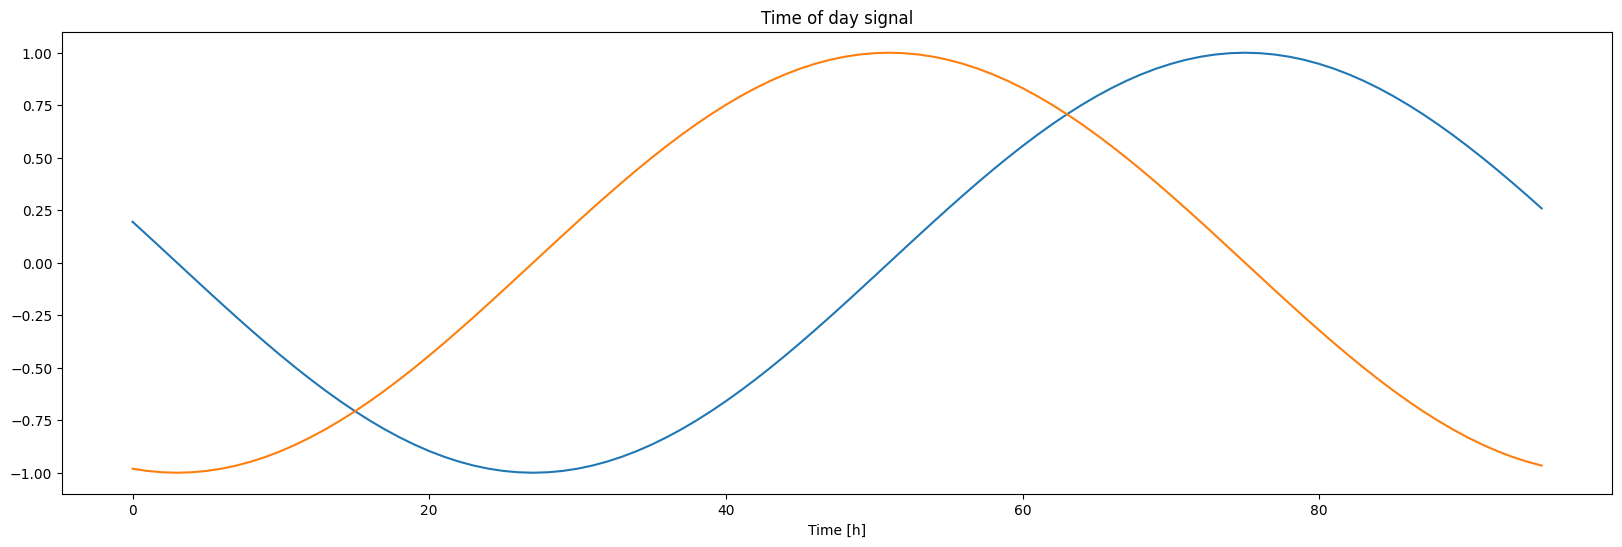

In [14]:
mins_15 = int(24*60/15)
print(f"Total data points {len(df)}")
print(f"Total data points in a day {mins_15}")

plt.plot(np.array(df['Day sin'])[:mins_15])
plt.plot(np.array(df['Day cos'])[:mins_15])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Total data points 138238
Total data points in a year 35064


Text(0.5, 1.0, 'Time of day signal')

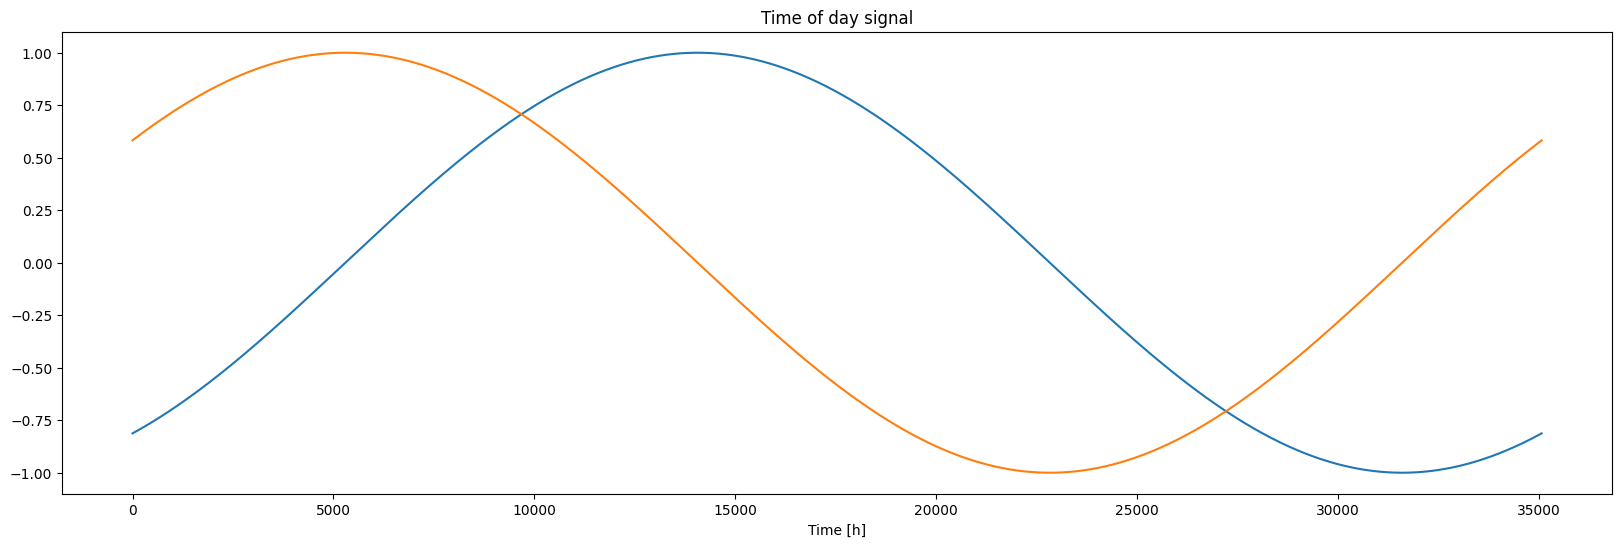

In [15]:
mins_15 = int(365.2524*24*60/15)
print(f"Total data points {len(df)}")
print(f"Total data points in a year {mins_15}")

plt.plot(np.array(df['Year sin'])[:mins_15])
plt.plot(np.array(df['Year cos'])[:mins_15])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [16]:
def manual_rfftfreq(n_samples, d):
    """
    Manual implementation of np.fft.rfftfreq()
    
    Parameters:
    n_samples (int): Number of samples in the original time domain signal
    d (float): Sample spacing (time between samples) in seconds
    
    Returns:
    numpy array: Array of frequencies corresponding to FFT output
    """
    # Calculate the sample rate (samples per second)
    sample_rate = 1.0 / d
    
    # For real FFT, we get n//2 + 1 frequency bins (including DC component)
    num_freq_bins = n_samples // 2 + 1
    
    # Calculate frequency increment between bins
    freq_increment = sample_rate / n_samples
    
    # Generate frequencies from 0 to Nyquist frequency
    frequencies = np.arange(num_freq_bins) * freq_increment
    
    return frequencies

# Example usage:
n_samples = len(df['current_power'])
sample_period = 15 * 60  # 15 minutes in seconds

# Manual calculation
manual_frequencies = manual_rfftfreq(n_samples, sample_period)
manual_frequencies[-1]

np.float64(0.0005555555555555556)

In [17]:
# Verify against NumPy's implementation
numpy_frequencies = np.fft.rfftfreq(n_samples, d=sample_period)

# Compare the first few values
print("Manual calculation:", manual_frequencies[:5])
print("NumPy calculation :", numpy_frequencies[:5])

Manual calculation: [0.00000000e+00 8.03766773e-09 1.60753355e-08 2.41130032e-08
 3.21506709e-08]
NumPy calculation : [0.00000000e+00 8.03766773e-09 1.60753355e-08 2.41130032e-08
 3.21506709e-08]


In [18]:
# Find peaks manually
def find_peaks_manual(x, min_prominence_ratio=0.01):
    peaks = []
    for i in range(1, len(x)-1):
        if x[i] > x[i-1] and x[i] > x[i+1]:
            peaks.append(i)

    print(peaks)
    
    max_val = x.max()
    threshold = max_val * min_prominence_ratio
    peaks = [p for p in peaks if x[p] > threshold]
    
    return np.array(peaks)

In [19]:
fft = tf.signal.rfft(df['current_power'])
max_val = np.abs(fft).max()
f_per_dataset = np.arange(0, len(fft))
years_per_dataset = n_samples/(sample_period)

f_per_year = f_per_dataset/years_per_dataset

In [20]:
# Get amplitude spectrum
amplitude_spectrum = np.abs(fft.numpy())  # Convert to NumPy array

# Find the peaks
peaks = find_peaks_manual(amplitude_spectrum)
# Convert peak indices to frequencies
peak_frequencies = f_per_year[peaks]

[4, 8, 12, 15, 17, 20, 24, 26, 28, 31, 35, 39, 43, 49, 55, 60, 62, 66, 69, 71, 73, 76, 79, 83, 86, 88, 91, 94, 99, 102, 107, 110, 112, 114, 117, 122, 124, 126, 130, 134, 138, 143, 146, 150, 152, 154, 160, 162, 166, 169, 173, 177, 181, 185, 187, 189, 192, 194, 198, 201, 204, 209, 213, 215, 217, 221, 225, 229, 231, 236, 238, 240, 244, 246, 249, 251, 253, 256, 258, 260, 262, 264, 267, 270, 272, 276, 280, 284, 286, 288, 292, 296, 298, 300, 303, 305, 307, 310, 315, 317, 319, 323, 327, 335, 337, 340, 343, 347, 351, 355, 358, 360, 362, 366, 368, 370, 372, 375, 380, 382, 384, 386, 388, 390, 394, 396, 398, 400, 403, 405, 408, 410, 414, 417, 421, 423, 426, 429, 433, 437, 441, 444, 448, 450, 452, 454, 456, 460, 465, 467, 469, 473, 476, 479, 481, 483, 485, 489, 492, 494, 498, 500, 503, 506, 508, 512, 516, 518, 524, 526, 528, 530, 533, 536, 538, 540, 545, 547, 553, 556, 564, 567, 572, 575, 578, 581, 583, 585, 587, 589, 592, 595, 597, 599, 601, 604, 606, 608, 610, 613, 615, 618, 621, 625, 628, 631, 

In [21]:
# Convert frequencies to periods
peak_periods = 1 / peak_frequencies

# Sort peaks by amplitude
sorted_indices = np.argsort(-amplitude_spectrum[peaks])
peaks = peaks[sorted_indices]
peak_frequencies = peak_frequencies[sorted_indices]
peak_periods = peak_periods[sorted_indices]

# Show results (top 5 peaks)
for i, (freq, period) in enumerate(zip(peak_frequencies[:5], peak_periods[:5])):
    print(f"Peak {i+1}: Frequency = {freq:.4f} cycles/year")
    
    # Convert to more intuitive units
    days = period * 365.25
    if days < 1:
        print(f"    Period ≈ {days*24:.2f} hours")
    elif days < 30:
        print(f"    Period ≈ {days:.2f} days")
    else:
        print(f"    Period ≈ {period*12:.2f} months")

Peak 1: Frequency = 9.3751 cycles/year
    Period ≈ 1.28 months
Peak 2: Frequency = 18.7503 cycles/year
    Period ≈ 19.48 days
Peak 3: Frequency = 28.1254 cycles/year
    Period ≈ 12.99 days
Peak 4: Frequency = 0.0260 cycles/year
    Period ≈ 460.79 months
Peak 5: Frequency = 9.4012 cycles/year
    Period ≈ 1.28 months


38.95969233888889
19.479846169444446
12.986564112962963


Text(0.5, 1.0, 'Frequency Spectrum of Current Power with Peak Frequencies')

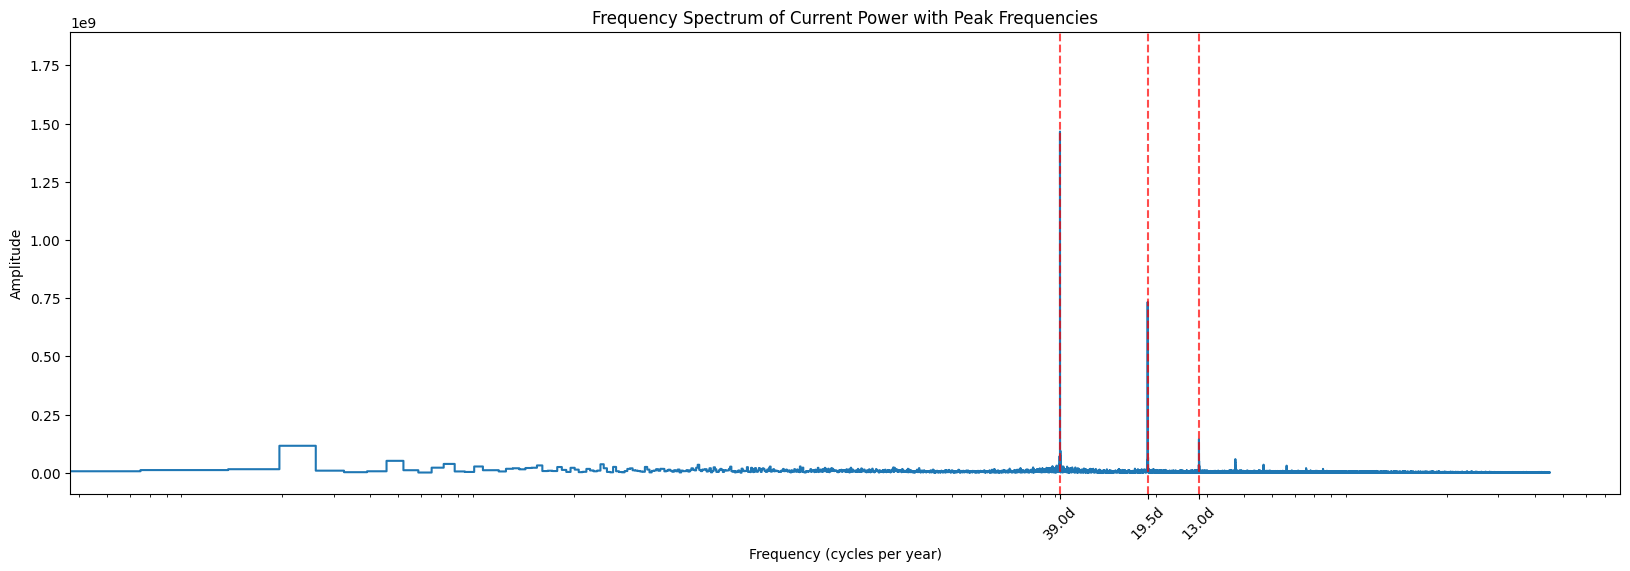

In [26]:
# Get top peaks (assuming you've already calculated them)
top_peaks = peak_frequencies[:3]  # Top 3 peaks

# Create frequency ticks including standard references and top peaks
#tick_locations = [1, 12, 52, 365.2524]  # Standard references (year, month, week, day)
tick_locations = []
tick_locations.extend(top_peaks)  # Add peak frequencies
tick_locations.sort()  # Sort them in ascending order

# Create corresponding labels
tick_labels = []
for freq in tick_locations:
    if abs(freq - 1) < 0.1:
        tick_labels.append('1/Year')
    elif abs(freq - 12) < 0.5:
        tick_labels.append('1/Month')
    elif abs(freq - 52) < 2:
        tick_labels.append('1/Week')
    elif abs(freq - 365.2524) < 10:
        tick_labels.append('1/Day')
    else:
        period_days = (1/freq) * 365.2524
        if period_days < 1:
            tick_labels.append(f'{period_days*24:.1f}h')
        else:
            tick_labels.append(f'{period_days:.1f}d')

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')

# Apply the customized ticks to your plot
plt.xticks(tick_locations, labels=tick_labels, rotation=45)

# Add a vertical line at each peak for emphasis
for freq in top_peaks:
    print((1/freq) * 365.2524)
    plt.axvline(x=freq, color='r', linestyle='--', alpha=0.7)

plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Current Power with Peak Frequencies')

In [27]:
day = 24*60*60
for freq in top_peaks:
    period_days = (1/freq) * 365.2524
    if period_days >= 1:
        print(period_days)
        sin_label = f'day_sin_{period_days:.1f}d'
        cos_label = f'day_cos_{period_days:.1f}d'
        df[sin_label] = np.sin(timestamp_s * (2 * np.pi / (period_days*day)))
        df[cos_label] = np.cos(timestamp_s * (2 * np.pi / (period_days*day)))
df.head(5)

38.95969233888889
19.479846169444446
12.986564112962963


,ambient_temperature,current_power,temperature_measurement,total_irradiation,utci_mean,cc,q,r,t,fal,...,Day sin,Day cos,Year sin,Year cos,day_sin_39.0d,day_cos_39.0d,day_sin_19.5d,day_cos_19.5d,day_sin_13.0d,day_cos_13.0d
datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,1.950903e-01,-0.980785,-0.812590,0.582835,0.473465,0.880813,0.834067,0.551663,0.995850,0.091010
2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,1.305262e-01,-0.991445,-0.812486,0.582981,0.474944,0.880016,0.835916,0.548857,0.996296,0.085990
2021-11-06 11:45:00,30.629213,47056.988764,57.235955,807.224719,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,6.540313e-02,-0.997859,-0.812381,0.583127,0.476421,0.879217,0.837755,0.546046,0.996717,0.080968
2021-11-06 12:00:00,31.021978,48415.835165,56.846154,817.527473,299.223424,0.0,0.011366,65.189689,293.320821,0.16517,...,7.114591e-12,-1.000000,-0.812277,0.583272,0.477898,0.878416,0.839585,0.543228,0.997112,0.075944
2021-11-06 12:15:00,31.831461,49345.404494,55.842697,816.651685,299.223424,0.0,0.011366,65.189689,293.320821,0.16517,...,-6.540313e-02,-0.997859,-0.812172,0.583418,0.479373,0.877611,0.841406,0.540404,0.997482,0.070918


38.95969233888889
19.479846169444446
12.986564112962963


Text(0.5, 1.0, 'Time of day signal')

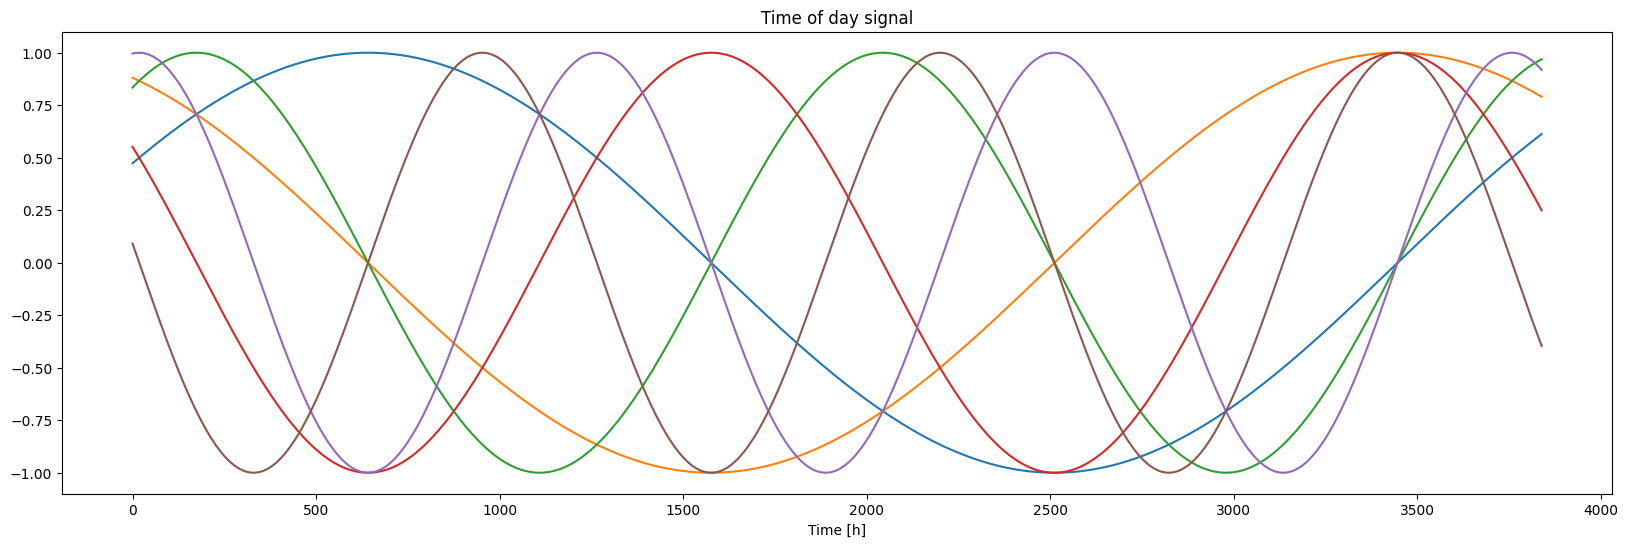

In [30]:
day = 24*60*60
mins_15 = int(40*24*60/15)
for freq in top_peaks:
    period_days = (1/freq) * 365.2524
    if period_days >= 1:
        print(period_days)
        sin_label = f'day_sin_{period_days:.1f}d'
        cos_label = f'day_cos_{period_days:.1f}d'
        plt.plot(np.array(df[sin_label])[:mins_15])
        plt.plot(np.array(df[cos_label])[:mins_15])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [28]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['season'] = df['month'] % 12 // 3 + 1
df['is_daytime'] = ((df['hour'] >= 6) & (df['hour'] <= 18)).astype(int)
df.head(5)

,ambient_temperature,current_power,temperature_measurement,total_irradiation,utci_mean,cc,q,r,t,fal,...,Day,year,month,day,hour,day_of_week,day_of_month,is_weekend,season,is_daytime
datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,6,2021,11,6,11,5,6,1,4,1
2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,6,2021,11,6,11,5,6,1,4,1
2021-11-06 11:45:00,30.629213,47056.988764,57.235955,807.224719,302.213731,0.0,0.011205,63.667006,293.487773,0.16517,...,6,2021,11,6,11,5,6,1,4,1
2021-11-06 12:00:00,31.021978,48415.835165,56.846154,817.527473,299.223424,0.0,0.011366,65.189689,293.320821,0.16517,...,6,2021,11,6,12,5,6,1,4,1
2021-11-06 12:15:00,31.831461,49345.404494,55.842697,816.651685,299.223424,0.0,0.011366,65.189689,293.320821,0.16517,...,6,2021,11,6,12,5,6,1,4,1


In [29]:
print(df.index.min())
print(df.index.max())

2021-11-06 11:15:00
2025-10-16 10:30:00


In [121]:
split_by = 'year'
years={'train': [2021, 2023, 2024], 'val': [2025], 'test': [2022]}
if split_by == 'year' and 'Year' in df.columns:
    print("use year")
    train_mask = df['Year'].isin(years['train'])
    val_mask = df['Year'].isin(years['val'])
    test_mask = df['Year'].isin(years['test'])

    train_df = df[train_mask]
    val_df = df[val_mask]
    test_df = df[test_mask]
elif split_by == 'custom':
    print("use custom")
    custom_ranges = {
        'train': [
            ('2021-11-06', '2021-12-31'),
            ('2023-11-06', '2024-12-31')
        ],
        'val': ('2025-01-01', '2025-10-16'),
        'test': ('2022-01-01', '2022-12-31')
    }
    train_mask = pd.Series(False, index=df.index)
    for train_range in custom_ranges['train']:
        train_start, train_end = train_range
        range_mask = (df.index >= train_start) & (df.index <= train_end)
        train_mask = train_mask | range_mask
        
    val_start, val_end = custom_ranges['val']
    val_mask = (df.index >= val_start) & (df.index <= val_end)
    
    test_start, test_end = custom_ranges['test']
    test_mask = (df.index >= test_start) & (df.index <= test_end)

    train_df = df[train_mask]
    val_df = df[val_mask]
    test_df = df[test_mask]

else:
    print("use percentage")
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

print(f"Number of train: {train_df.shape}")
print(f"Number of validation: {val_df.shape}")
print(f"Number of test: {test_df.shape}")

use year
Number of train: (75507, 42)
Number of validation: (27691, 42)
Number of test: (35040, 42)


In [133]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

    excluded = label_columns
    numerical_features = self.train_df.select_dtypes(include=[np.number]).columns.tolist()
      
    self.feature_columns = [col for col in numerical_features if col not in excluded]
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='current_power', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [15min]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [134]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [135]:
val_performance = {}
performance = {}

In [136]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['current_power'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['current_power']

In [138]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [139]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

NameError: name 'conv_window' is not defined